In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
os.environ["OMP_NUM_THREADS"] = "4"
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats


In [80]:
# read preprocessed data
data = pd.read_csv("data/complete_dataset.csv")
data = data.drop('Unnamed: 0', axis=1)  
data = data.iloc[:1000]
# separate the predictors and the criterion variable
trainCrit = data['Heart_Disease']  
data = data.drop('Heart_Disease', axis=1)  


In [81]:
data

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,1,4,0,0,0,0,0,1,1,82,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,4,5,0,0,0,0,1,0,1,82,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,4,5,1,0,0,0,1,0,1,82,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,1,5,1,0,0,0,1,0,0,77,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,3,5,0,0,0,0,0,0,0,82,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,5,1,0,0,0,0,0,1,82,175.0,81.65,26.58,1,0.0,30.0,5.0,0.0
996,4,5,0,0,0,1,0,0,0,82,175.0,97.52,31.75,0,0.0,30.0,30.0,12.0
997,3,3,1,0,0,0,0,0,0,82,191.0,104.33,28.75,1,12.0,20.0,16.0,2.0
998,4,5,1,0,0,0,0,0,0,82,193.0,81.65,21.91,0,7.0,30.0,0.0,20.0


## PCA

[0.58298364 0.20196009 0.42314985 0.09225932 0.14023137 0.3331087
 0.4535311  0.51052941 0.76407415 0.08590135 0.79258595 0.70247751
 0.62341934 0.16637093 0.35446449 0.07334991 0.22082638 0.1367086 ]
                         Feature  Importance
10                   Height_(cm)    0.119044
8                            Sex    0.114761
11                   Weight_(kg)    0.105510
12                           BMI    0.093636
0                 General_Health    0.087562
7                      Arthritis    0.076680
6                       Diabetes    0.068119
2                       Exercise    0.063556
14           Alcohol_Consumption    0.053239
5                     Depression    0.050032
16  Green_Vegetables_Consumption    0.033167
1                        Checkup    0.030334
13               Smoking_History    0.024988
4                   Other_Cancer    0.021062
17       FriedPotato_Consumption    0.020533
3                    Skin_Cancer    0.013857
9                   Age_Category  

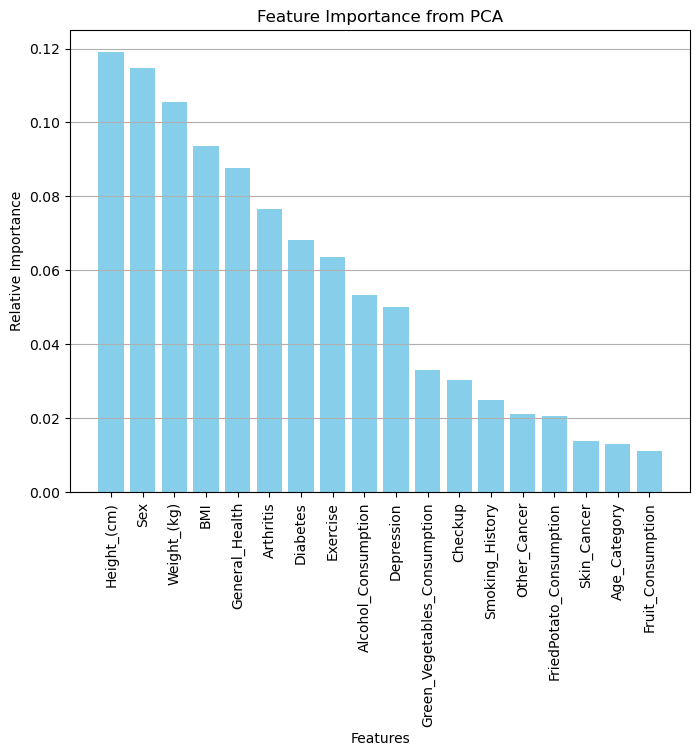

In [82]:
# scale data, so that all variables contribute equally
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply PCA, get 2 principal components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

components = np.abs(pca.components_)  # Absolute value of eigenvectors
print(components.sum(axis=0))

# Compute total importance of each feature
feature_importance = components.sum(axis=0)
# Normalize importance (optional)
feature_importance_normalized = feature_importance / feature_importance.sum()
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': data.columns,
    'Importance': feature_importance_normalized
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance from PCA')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

## 1. K-means algorithm

### Find out the best k for k-means using the "elbow method"

In [83]:
data_kmeans = data.copy()
data_kmeans = data_kmeans.apply(lambda x: (x - x.min()) / (x.max() - x.min())) # Normalize the data
data_kmeans

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0.00,0.75,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.211268,0.000000,0.012715,1.0,0.000000,0.250000,0.133333,0.100000
1,0.75,1.00,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.422535,0.328845,0.376954,0.0,0.000000,0.250000,0.000000,0.033333
2,0.75,1.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.394366,0.412740,0.514172,0.0,0.133333,0.100000,0.025000,0.133333
3,0.00,1.00,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.633803,0.449656,0.388609,0.0,0.000000,0.250000,0.250000,0.066667
4,0.50,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.788732,0.412740,0.273113,1.0,0.000000,0.066667,0.033333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.00,1.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.563380,0.362432,0.331656,1.0,0.000000,0.250000,0.041667,0.000000
996,0.75,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.563380,0.479840,0.468609,0.0,0.000000,0.250000,0.250000,0.100000
997,0.50,0.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.788732,0.530221,0.389139,1.0,0.400000,0.166667,0.133333,0.016667
998,0.75,1.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.816901,0.362432,0.207947,0.0,0.233333,0.250000,0.000000,0.166667


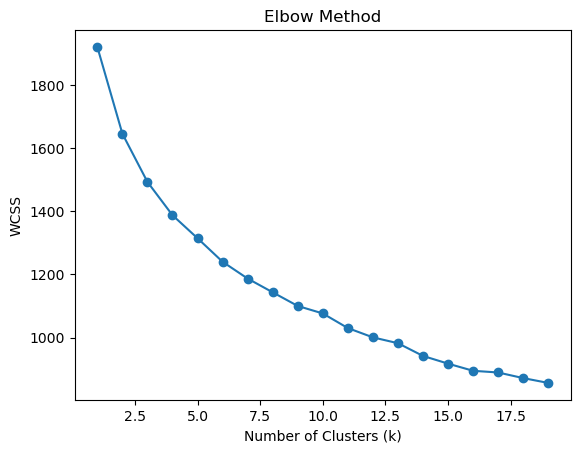

In [84]:
wcss = [] # wcss = Within-Cluster Sum of Squares, measures total variance within each cluster, which we aim to minimize
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # 10 rounds repeat (since performance dependend on random first centers)
    kmeans.fit(data_kmeans)
    wcss.append(kmeans.inertia_) # inertia is wcss for specific k
    
plt.plot(range(1, 20), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [85]:
# The optimal point for k seems to be k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# Fit the model
kmeans.fit(data_kmeans)
# Get the cluster assignments
y_kmeans = kmeans.predict(data_kmeans)
data_kmeans['Cluster assignment'] = y_kmeans

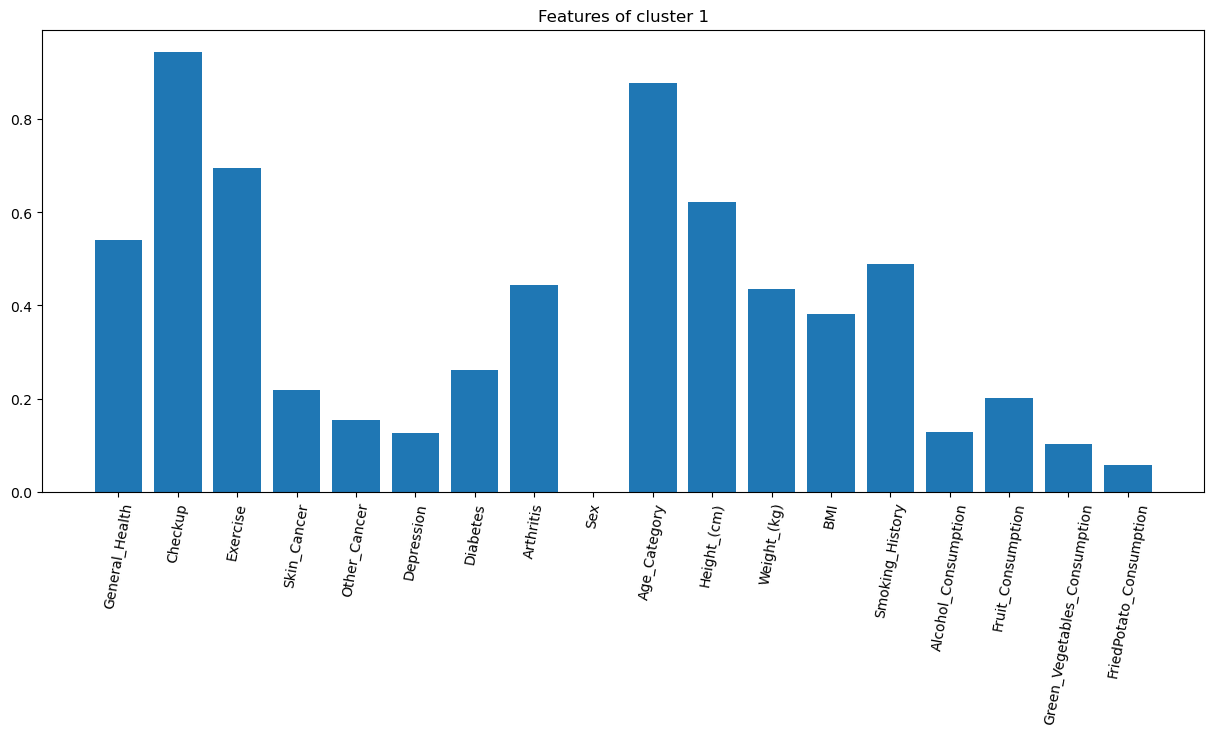

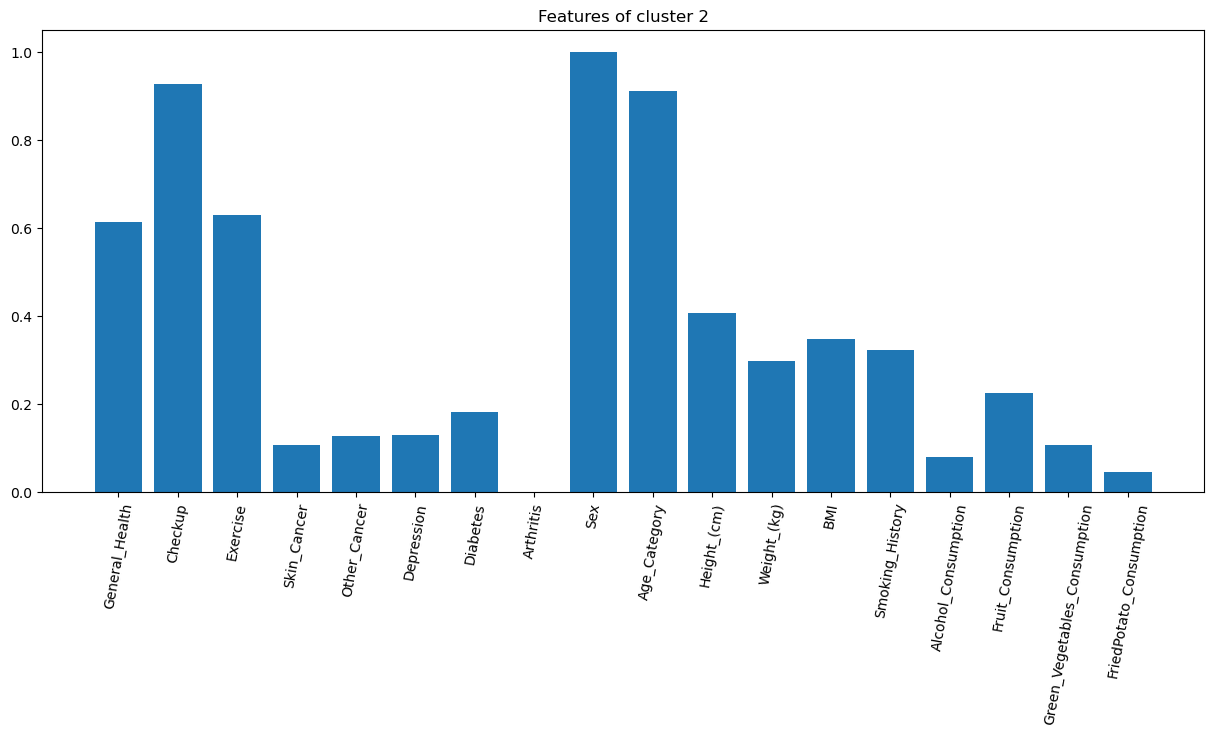

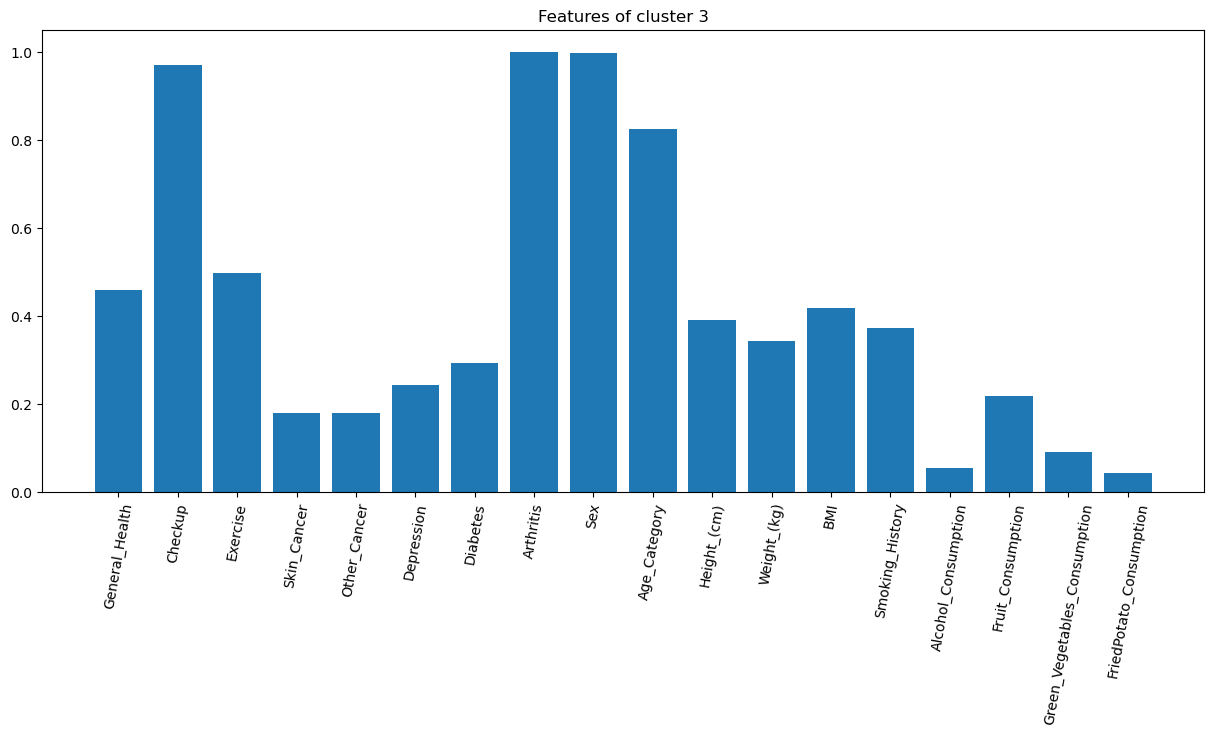

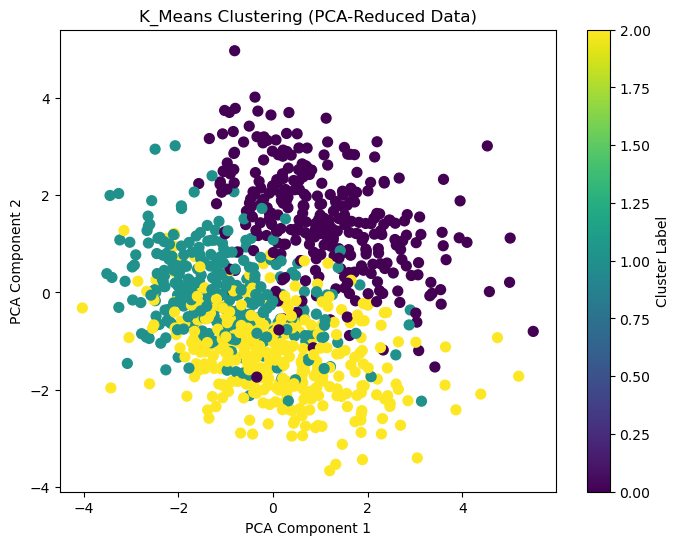

In [86]:
clusters = []
for i in range(0, max(data_kmeans['Cluster assignment']) + 1):
    clusters.append(np.mean(data_kmeans[data_kmeans['Cluster assignment'] == i], axis=0)[:-1])

for i in range(0, len(clusters)):
    plt.figure(figsize=(15, 6))
    plt.bar(clusters[i].index, clusters[i])
    plt.title(f"Features of cluster {i+1}")
    plt.xticks(rotation=80)  # Rotate the labels 45 degrees
    plt.show()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
X = np.array(scaled_data)
labels = data_kmeans['Cluster assignment']

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title("K_Means Clustering (PCA-Reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

Sex                             0.998549
Arthritis                       0.106343
Depression                      0.066180
Fruit_Consumption               0.020520
Checkup                         0.005678
BMI                             0.003515
Other_Cancer                    0.000957
Green_Vegetables_Consumption   -0.005464
General_Health                 -0.013058
FriedPotato_Consumption        -0.014858
Age_Category                   -0.015694
Diabetes                       -0.018070
Alcohol_Consumption            -0.063177
Skin_Cancer                    -0.072060
Weight_(kg)                    -0.112650
Exercise                       -0.138656
Smoking_History                -0.138964
Height_(cm)                    -0.223913
dtype: float64
6.5


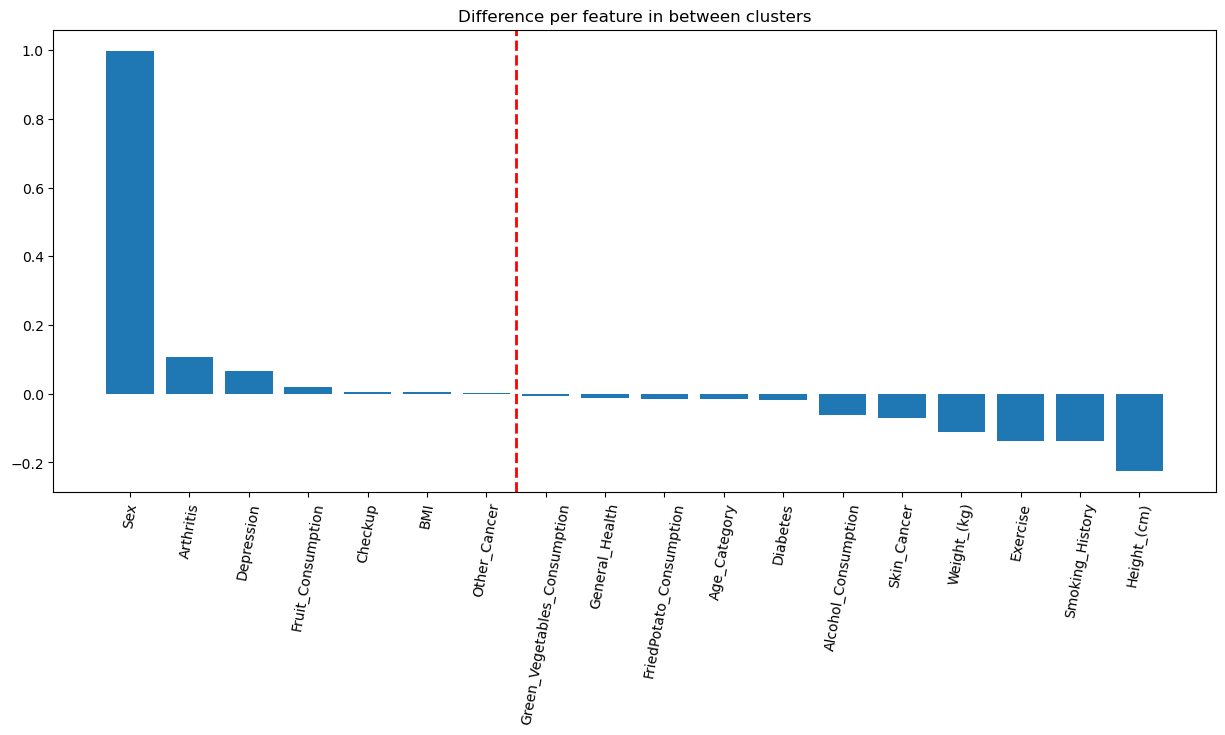

In [89]:
# only possible if k=2
# The optimal point for k seems to be k=3
kmeans = KMeans(n_clusters=2, random_state=13, n_init=10)
# Fit the model
kmeans.fit(data_kmeans)
# Get the cluster assignments
y_kmeans = kmeans.predict(data_kmeans)
data_kmeans['Cluster assignment'] = y_kmeans

clusters = []
for i in range(0, max(data_kmeans['Cluster assignment']) + 1):
    clusters.append(np.mean(data_kmeans[data_kmeans['Cluster assignment'] == i], axis=0)[:-1])

# get difference
s1, s2 = clusters    
difference = s2 -s1

difference = difference.sort_values(ascending=False)
print(difference)

x_position = list(difference.index).index("Green_Vegetables_Consumption")-0.5
print(x_position)
plt.figure(figsize=(15, 6))
plt.bar(difference.index, difference)
plt.axvline(x=x_position, color='red', linestyle='--', linewidth=2)
plt.title(f"Difference per feature in between clusters")
plt.xticks(rotation=80)  # Rotate the labels 45 degrees
plt.show()

In [110]:
# see correlations between clusters and heart disease
pd.crosstab(data_kmeans['Cluster assignment'], trainCrit)
#print(clusters, data_kmeans['Cluster assignment'])

Heart_Disease,0,1
Cluster assignment,,
0,244,68
1,615,73


In [111]:
scipy.stats.spearmanr(data_kmeans['Cluster assignment'], trainCrit).correlation   # Spearman's rho

-0.14889438767163948

In [ ]:
# ???
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)
X_pca.shape

(1000, 2)

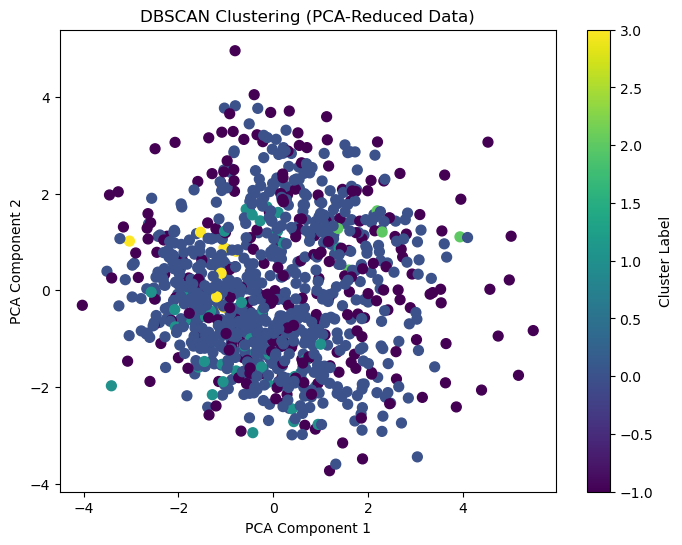

In [112]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
X = np.array(scaled_data)
#X, _ = make_blobs(n_samples=200, n_features=19, centers=3, random_state=42)

dbscan = DBSCAN(eps=3, min_samples=5)
labels = dbscan.fit_predict(X)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title("DBSCAN Clustering (PCA-Reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [ ]:
dbscan.fit_predict(data)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1